In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DATA_PATH = "/kaggle/input/llm-classification-finetuning/"

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


# **Data Loading**

In [37]:
data = pd.read_csv(DATA_PATH + "train.csv")
test_data = pd.read_csv(DATA_PATH + "test.csv")
#Make lists actual lists, pandas defaults to strings when reading from CSV file
list_cols = ["prompt", "response_a", "response_b"]

for col in list_cols:
    data[col] = data[col].apply(json.loads)
    test_data[col] = test_data[col].apply(json.loads)

# **Functions** 

In [38]:
#Combine winner into 1 column
#Winner: 0 = tie; 1 = model_a; 2 = model_b

def combine_winner(row):
    """
    Function to assign value to winner column
    """
    if row["winner_tie"] == 1:
        return 0  # tie
    elif row["winner_model_a"] == 1:
        return 1  # model A wins
    else:
        return 2  # model B wins

def get_single_winner_col(dataframe): 
    """
    Combines the 3 winner columns into a single column where 0 = tie; 1 = model_a; 2 = model_b

    Parameters:
        df (pd.DataFrame): input DataFrame

    Returns:
        pd.DataFrame: new DataFrame with a single winner column
    """
    df = dataframe.copy()
    df["winner"] = df.apply(combine_winner, axis=1)
    df = df.drop(columns=["winner_model_a", "winner_model_b", "winner_tie"])
    return df


#Split prompts/response into individual entries. Can access through id
def expand_df(dataframe):
    """
    Splits lists of prompts and responses in the dataframe into individual entries.

    Parameters:
        df (pd.DataFrame): input DataFrame

    Returns:
        pd.DataFrame: new DataFrame with each entry having a single prompt and pair of responses
    """
    df = dataframe.copy()
    df["triples"] = df.apply(
        lambda row: list(zip(row["prompt"], row["response_a"], row["response_b"])),
        axis=1
    )
    
    df_expanded = df.explode("triples").reset_index(drop=True)
    
    # Split back into separate columns
    df_expanded["prompt"] = df_expanded["triples"].apply(lambda x: x[0])
    df_expanded["response_a"] = df_expanded["triples"].apply(lambda x: x[1])
    df_expanded["response_b"] = df_expanded["triples"].apply(lambda x: x[2])
    
    df_expanded = df_expanded.drop(columns=["triples"])
    return df_expanded

def lowercase_df(dataframe):
    """
    Lowercase all string columns in a DataFrame.
    """
    df = dataframe.copy()
    
    # Select object/string columns
    str_cols = df.select_dtypes(include='object').columns
    
    # Apply str.lower() to each column
    for col in str_cols:
        df[col] = df[col].str.lower()
    
    return df


def update_ids(dataframe, keep_old = True):
    """
    Replace the `id` column with continuous integers starting from 0.

    Parameters:
        dataframe (pd.DataFrame): input DataFrame
        keep_old (bool): if True, keep original IDs in a new column 'old_id'

    Returns:
        pd.DataFrame: new DataFrame with regularized IDs
    """
    df = dataframe.copy()  # avoid modifying the original
    
    if keep_old:
        df["old_id"] = df["id"]
    
    df["id"] = range(len(df))
    
    return df

# **Data Preprocessing**

In [39]:
#Base Panda DF
data;

#DF where winners represented in a single column "winner"
#winner: 0 = tie; 1 = model_a; 2 = model_b
base_df = get_single_winner_col(data)

#df where prompt/responses are split individually and respectively. 
#Ex: prompt: ["1", "2"] response_a: ["a1", "a2"] response_b: ["b1", "b2"]
#Becomes: prompt: ["1"] response_a: ["a1"] response_b: ["b1"]; prompt: ["2"] response_a: ["a2"] response_b: ["b2"]
#Other columns are kept and maintained
individual_response_df = expand_df(base_df)


# **Processced Data**

In [40]:
#Option so you can see the whole prompt/responses
#pd.set_option("display.max_colwidth", None)

In [41]:
#original_df has columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']
original_df = data

#df has columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner']
#Where winner = 0: tie, 1: model_a, 2: model_b 
#And each prompt and response contains a single string.
df = lowercase_df(individual_response_df)
#df values
column_names = list(df.columns)
unique_models = pd.unique(data[["model_a", "model_b"]].values.ravel())
ids = data["id"]

#test data has columns: ['id', 'prompt', 'response_a', 'response_b']
#each prompt and response are lists of strings
test_data;

In [42]:
print(type(df.iloc[0]['response_a']))

<class 'str'>


# **Data Visualization**

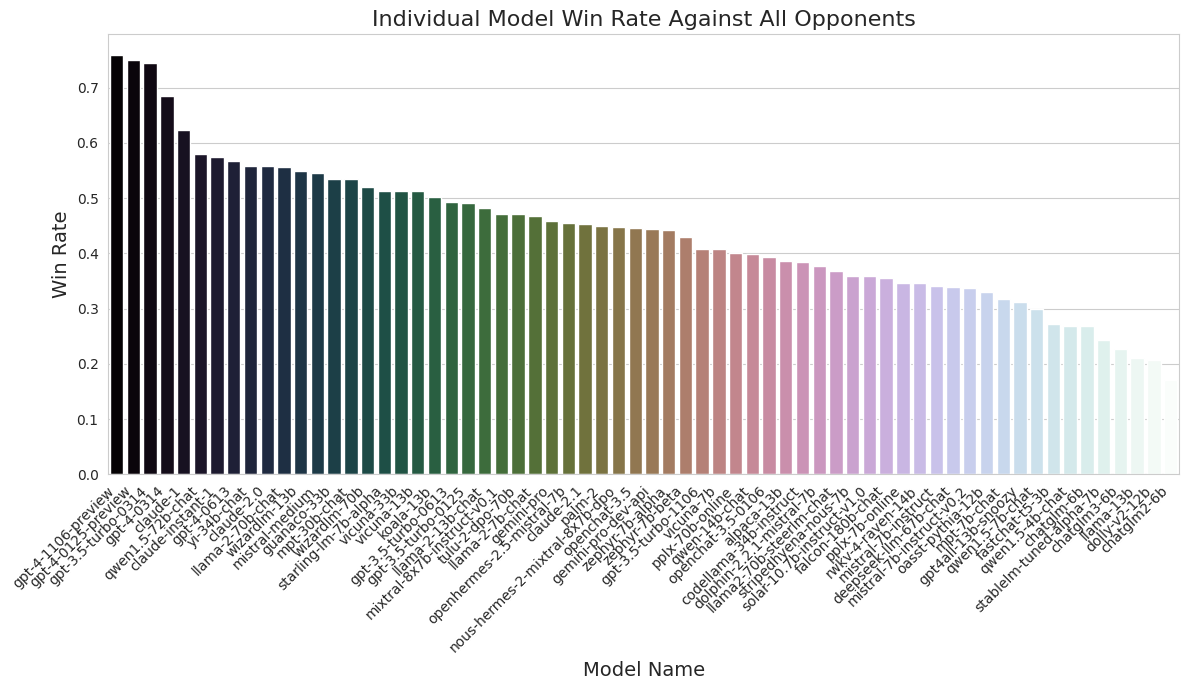

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import json
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Set consistent style for all plots
sns.set_style("whitegrid")
def plot_individual_model_win_rate(df):
    """
    Calculates and plots the overall win rate for each unique model 
    across all comparisons it participated in. (Win Rate = Wins / (Wins + Losses))
    """
    
    # 1. Extract all unique model names
    unique_models = pd.unique(df[['model_a', 'model_b']].values.ravel())
    
    results = {}
    
    for model in unique_models:
        # When model is 'model_a'
        a_wins = df[(df['model_a'] == model) & (df['winner'] == 1)].shape[0]
        a_losses = df[(df['model_a'] == model) & (df['winner'] == 2)].shape[0]
        
        # When model is 'model_b'
        b_wins = df[(df['model_b'] == model) & (df['winner'] == 2)].shape[0]
        b_losses = df[(df['model_b'] == model) & (df['winner'] == 1)].shape[0]
        
        # Aggregate results (excluding ties from Win Rate calculation)
        total_wins = a_wins + b_wins
        total_losses = a_losses + b_losses
        total_games = total_wins + total_losses
        
        win_rate = total_wins / total_games if total_games > 0 else 0
        
        results[model] = {
            'Win Rate': win_rate,
            'Total Games': total_games,
        }

    # 2. Convert to DataFrame and sort by Win Rate
    win_rate_df = pd.DataFrame.from_dict(results, orient='index')
    win_rate_df = win_rate_df.sort_values(by='Win Rate', ascending=False)
    
    # 3. Plot the bar chart
    plt.figure(figsize=(12, 7))
    
    # 准备数据，重置索引以避免 IndexingError
    plot_df = win_rate_df.reset_index().rename(columns={'index': 'Model Name'})

    ax = sns.barplot(
        data=plot_df,
        x='Model Name',
        y='Win Rate',
        hue='Model Name',
        palette='cubehelix',
        dodge=False
    )
    try:
        ax.get_legend().remove()
    except AttributeError:
        pass

    plt.title('Individual Model Win Rate Against All Opponents', fontsize=16)
    plt.xlabel('Model Name', fontsize=14)
    plt.ylabel('Win Rate', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
    
# Model ability
plot_individual_model_win_rate(df)

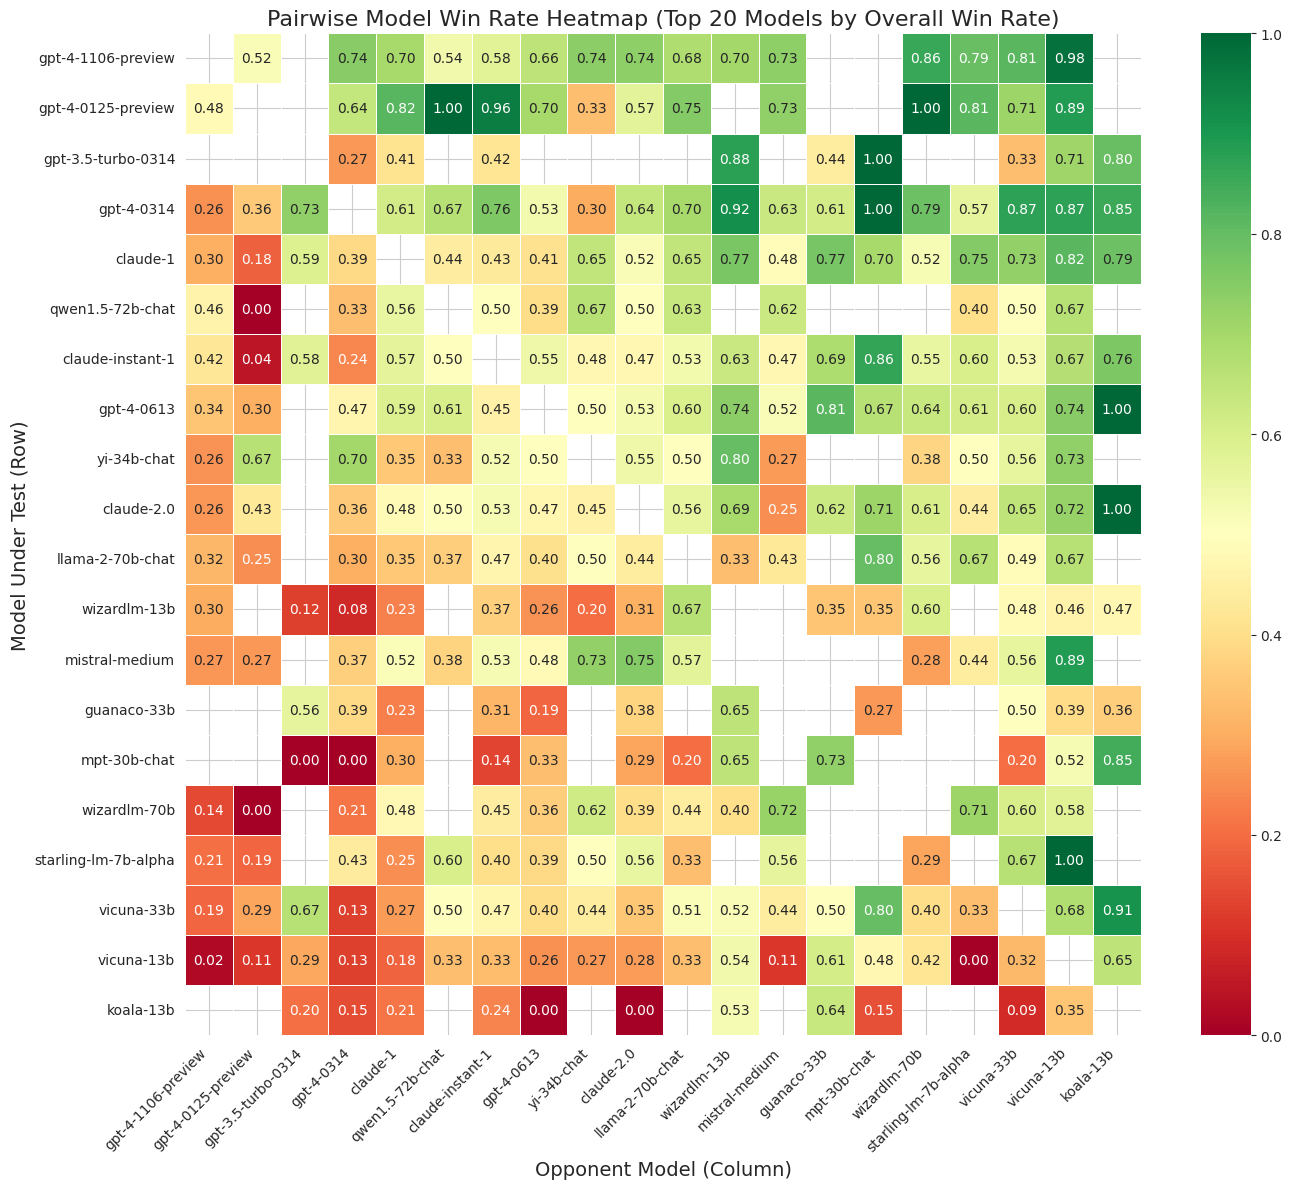

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_individual_model_win_rate_heatmap(df, top_n=20):
    """
    Plots a heatmap showing the win rate of the row model against the column model.
    Only includes the top_n most frequently played models, sorted by overall win rate.
    """
    # Ensure df is a DataFrame (for robustness, though likely already is)
    if not isinstance(df, pd.DataFrame):
        print("Input must be a pandas DataFrame.")
        return
        
    unique_models = pd.unique(df[['model_a', 'model_b']].values.ravel())
    results = {}

    for model in unique_models:
        # Calculate Wins, Losses, and Total Games (excluding ties)
        # These are boolean masks.
        a_wins = (df['model_a'] == model) & (df['winner'] == 1)
        a_losses = (df['model_a'] == model) & (df['winner'] == 2)
        b_wins = (df['model_b'] == model) & (df['winner'] == 2)
        b_losses = (df['model_b'] == model) & (df['winner'] == 1)

        # sum() converts True/False to 1/0
        total_wins = a_wins.sum() + b_wins.sum()
        total_losses = a_losses.sum() + b_losses.sum()
        total_games = total_wins + total_losses

        win_rate = total_wins / total_games if total_games > 0 else 0

        results[model] = {
            'Win Rate': win_rate,
            'Total Games': total_games,
        }

    win_rate_df = pd.DataFrame.from_dict(results, orient='index')

    # Filter: Keep models with Total Games > 0
    win_rate_df = win_rate_df[win_rate_df['Total Games'] > 0]

    # Determine the top models: sort by Win Rate descending, then Total Games descending
    top_models_list = win_rate_df.sort_values(
        by=['Win Rate', 'Total Games'], ascending=[False, False]
    ).head(top_n).index.tolist()

    if len(top_models_list) < 2:
        print(f"Less than 2 models qualified for the Top {top_n} list. Skipping heatmap.")
        return

    # Recalculate the heatmap matrix using only the top models
    heatmap_df = pd.DataFrame(index=top_models_list, columns=top_models_list, dtype=float)

    for model_row in top_models_list:
        for model_col in top_models_list:
            if model_row == model_col:
                heatmap_df.loc[model_row, model_col] = np.nan
                continue

            # Count Model_row vs Model_col matchups (A vs B and B vs A cases)
            
            df_ab = df[(df['model_a'] == model_row) & (df['model_b'] == model_col)]
            a_wins = (df_ab['winner'] == 1).sum()
            a_losses = (df_ab['winner'] == 2).sum()

            df_ba = df[(df['model_a'] == model_col) & (df['model_b'] == model_row)]
            b_wins = (df_ba['winner'] == 2).sum()
            b_losses = (df_ba['winner'] == 1).sum()

            total_wins = a_wins + b_wins
            total_losses = a_losses + b_losses
            total_games = total_wins + total_losses

            # Win rate of model_row against model_col
            win_rate = total_wins / total_games if total_games > 0 else np.nan

            heatmap_df.loc[model_row, model_col] = win_rate

    plt.figure(figsize=(14, 12))
    
    ax = sns.heatmap(
        heatmap_df,
        cmap='RdYlGn',
        linewidths=.5,
        annot=True,
        fmt=".2f",
    )

    plt.title(f'Pairwise Model Win Rate Heatmap (Top {top_n} Models by Overall Win Rate)', fontsize=16)
    plt.xlabel('Opponent Model (Column)', fontsize=14)
    plt.ylabel('Model Under Test (Row)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

plot_individual_model_win_rate_heatmap(df)

<Figure size 1200x800 with 0 Axes>

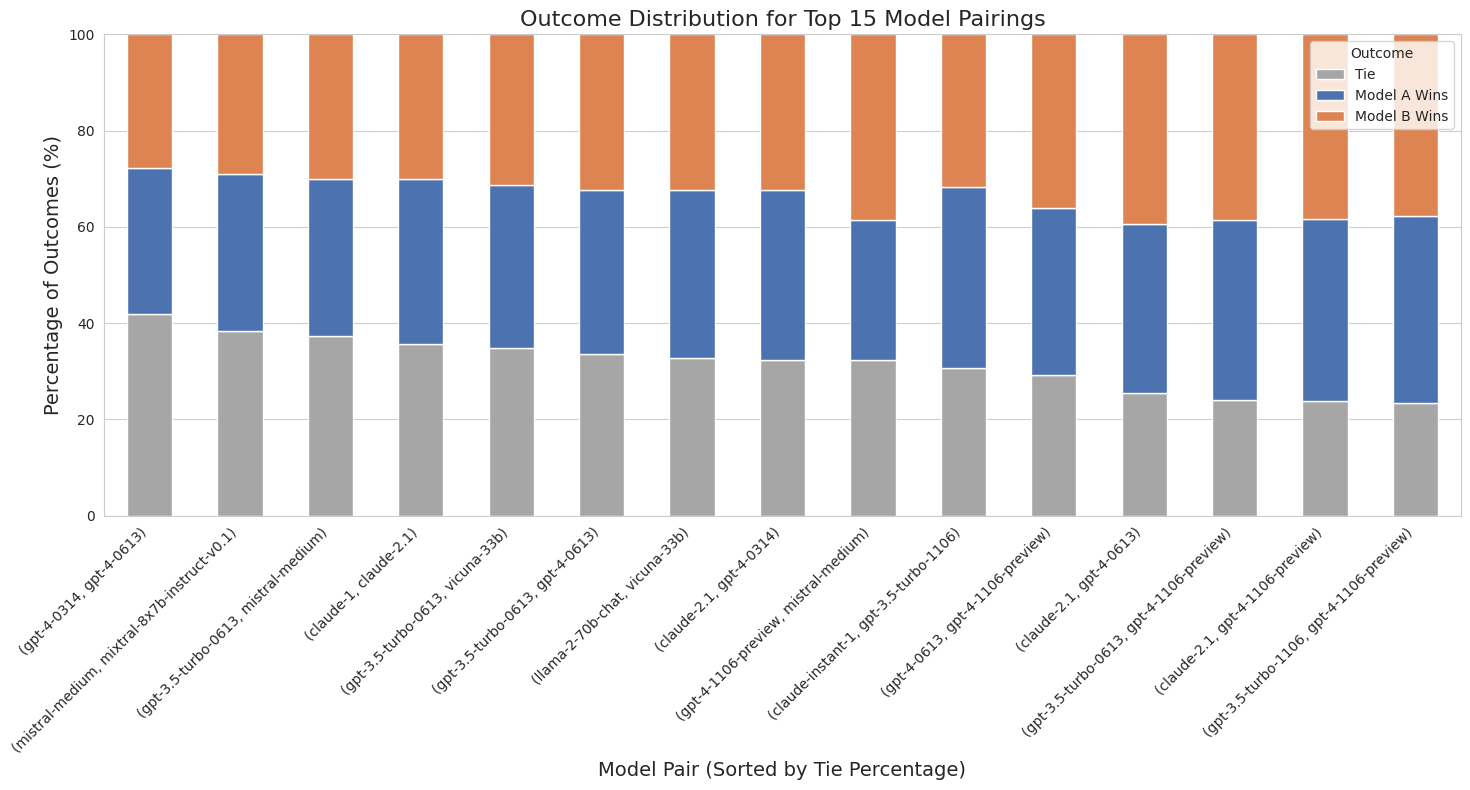

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_model_pair_outcome_distribution(df, top_n_pairs=15):
    """
    Analyzes the outcome distribution (Win A, Win B, Tie) for the 
    top N most frequent model pairings (ignoring position A/B).
    """ 
    df_plot = df.copy()

    # 1. Create a unique identifier for the model pair (position agnostic)
    # Ensure model names are sorted alphabetically so (A, B) and (B, A) are treated as the same pair
    df_plot['model_pair'] = df_plot.apply(
        lambda row: tuple(sorted((row['model_a'], row['model_b']))), axis=1
    )

    # 2. Count the Top N most frequent model pairs
    pair_counts = df_plot['model_pair'].value_counts()
    top_pairs = pair_counts.head(top_n_pairs).index.tolist()

    # 3. Filter the data, keeping only the Top N pairings
    df_filtered = df_plot[df_plot['model_pair'].isin(top_pairs)].copy()

    # 4. Calculate the counts of outcomes for each pairing
    outcome_by_pair = df_filtered.groupby('model_pair')['winner'].value_counts().unstack(fill_value=0)

    # Rename columns for readability
    # Winner codes: 0=Tie, 1=Model A Wins, 2=Model B Wins
    outcome_by_pair.columns = ['Tie', 'Model A Wins', 'Model B Wins']

    # 5. Calculate percentages
    outcome_by_pair['Total'] = outcome_by_pair.sum(axis=1)
    for col in outcome_by_pair.columns[:-1]:
        outcome_by_pair[col] = (outcome_by_pair[col] / outcome_by_pair['Total']) * 100

    # 6. Prepare plot data (keep percentages, sort by Tie percentage descending)
    plot_df = outcome_by_pair.drop(columns=['Total']).sort_values(by='Tie', ascending=False)

    # 7. Plot the stacked bar chart
    plt.figure(figsize=(12, 8))

    # Use pd.DataFrame.plot(kind='bar', stacked=True) to draw the stacked chart
    ax = plot_df.plot(
        kind='bar', 
        stacked=True, 
        figsize=(15, 8),
        color=['#A6A6A6', '#4C72B0', '#DD8452'] # Tie: Grey, Model A: Blue, Model B: Orange
    )
    
    ax.set_title(f'Outcome Distribution for Top {top_n_pairs} Model Pairings', fontsize=16)
    ax.set_xlabel('Model Pair (Sorted by Tie Percentage)', fontsize=14)
    ax.set_ylabel('Percentage of Outcomes (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.legend(title='Outcome', loc='upper right')
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

plot_model_pair_outcome_distribution(df)

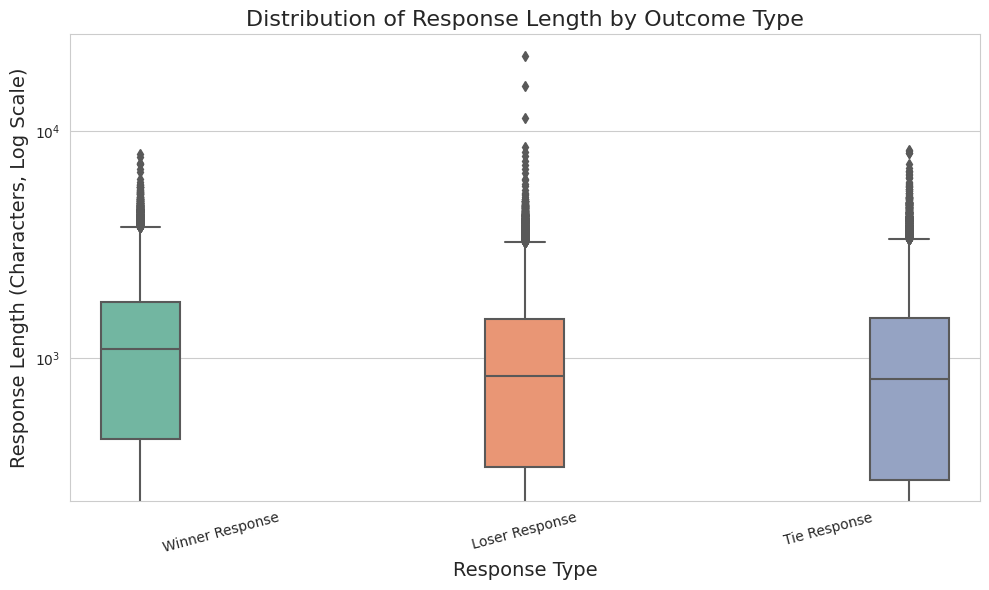

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_response_length_by_winner(df):
    """
    Compares the distribution of response lengths between winning, losing, and tied responses.
    FIX: Uses dropna to handle NoneType error before applying len().
    """
    df_plot = df.copy()

    df_plot = df_plot.dropna(subset=['response_a', 'response_b']).copy()

    # 1. Calculate response lengths
    df_plot['len_a'] = df_plot['response_a'].apply(len)
    df_plot['len_b'] = df_plot['response_b'].apply(len)

    # 2. Prepare data for box plot (Winner, Loser, Tie)

    # Winning response length (Model A winner=1, Model B winner=2)
    df_plot['winner_len'] = df_plot.apply(
        lambda row: row['len_a'] if row['winner'] == 1
        else (row['len_b'] if row['winner'] == 2 else np.nan), axis=1
    )
    # Losing response length
    df_plot['loser_len'] = df_plot.apply(
        lambda row: row['len_b'] if row['winner'] == 1
        else (row['len_a'] if row['winner'] == 2 else np.nan), axis=1
    )

    # Combine data frames with English labels
    winner_df = df_plot[df_plot['winner'].isin([1, 2])].rename(columns={'winner_len': 'Response Length'})
    winner_df['Type'] = 'Winner Response'

    loser_df = df_plot[df_plot['winner'].isin([1, 2])].rename(columns={'loser_len': 'Response Length'})
    loser_df['Type'] = 'Loser Response'

    # Tie responses (both A and B responses in a tie comparison)
    tie_df = df_plot[df_plot['winner'] == 0]

    tie_a = tie_df[['len_a']].rename(columns={'len_a': 'Response Length'})
    tie_b = tie_df[['len_b']].rename(columns={'len_b': 'Response Length'})
    tie_a['Type'] = 'Tie Response'
    tie_b['Type'] = 'Tie Response'

    final_df = pd.concat([
        winner_df[['Response Length', 'Type']],
        loser_df[['Response Length', 'Type']],
        tie_a[['Response Length', 'Type']],
        tie_b[['Response Length', 'Type']]
    ]).dropna(subset=['Response Length'])

    # 3. Plot the box plot
    plt.figure(figsize=(10, 6))
    
    ax = sns.boxplot(
        x='Type',
        y='Response Length',
        data=final_df,
        hue='Type',
        palette='Set2'
    )
    
    try:
        if ax.legend_:
            ax.legend_.remove()
    except AttributeError:
        pass

    # Use log scale as response lengths can vary widely
    plt.yscale('log')

    plt.title('Distribution of Response Length by Outcome Type', fontsize=16)
    plt.xlabel('Response Type', fontsize=14)
    plt.ylabel('Response Length (Characters, Log Scale)', fontsize=14)
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()

plot_response_length_by_winner(df)

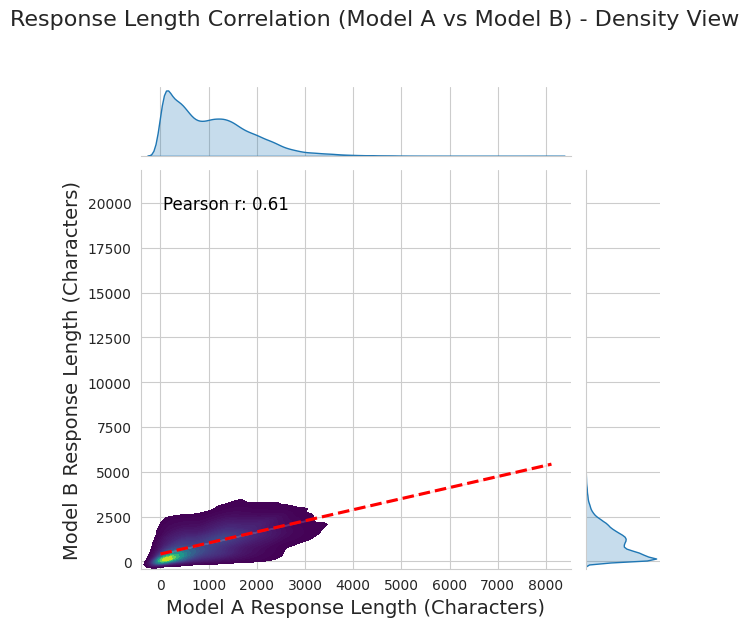

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_response_length_correlation(df):
    """
    Plots Model A response length vs Model B response length using a
    Kernel Density Estimate (KDE) plot to better visualize data density.
    """
    df_plot = df.copy()

    # 1. Calculate response lengths
    df_plot = df_plot.dropna(subset=['response_a', 'response_b']).copy()
    df_plot['len_a'] = df_plot['response_a'].apply(len)
    df_plot['len_b'] = df_plot['response_b'].apply(len)

    # 2. Plot the jointplot using KDE kind
    # The jointplot function and its 'kind' argument are robust.
    g = sns.jointplot(
        x='len_a',
        y='len_b',
        data=df_plot,
        kind='kde',
        cmap='viridis',
        fill=True,
        n_levels=30,
    )

    # 3. Calculate and add Pearson correlation coefficient
    r, p = pearsonr(df_plot['len_a'], df_plot['len_b'])

    # Add regression line (scatter=False hides the points, showing only the line)
    # The regplot functionality is robust.
    sns.regplot(
        x='len_a',
        y='len_b',
        data=df_plot,
        scatter=False,
        ax=g.ax_joint,
        color='red',
        line_kws={'linestyle':'--'}
    )

    # Add Pearson r value to the plot
    g.ax_joint.text(
        0.05, 0.9,
        f'Pearson r: {r:.2f}',
        transform=g.ax_joint.transAxes,
        fontsize=12,
        color='black'
    )

    # Set English titles and labels
    g.fig.suptitle('Response Length Correlation (Model A vs Model B) - Density View', fontsize=16, y=1.03)
    g.set_axis_labels('Model A Response Length (Characters)', 'Model B Response Length (Characters)', fontsize=14)

    # Increase top margin
    g.fig.subplots_adjust(top=0.9)

    plt.show()

plot_response_length_correlation(df)

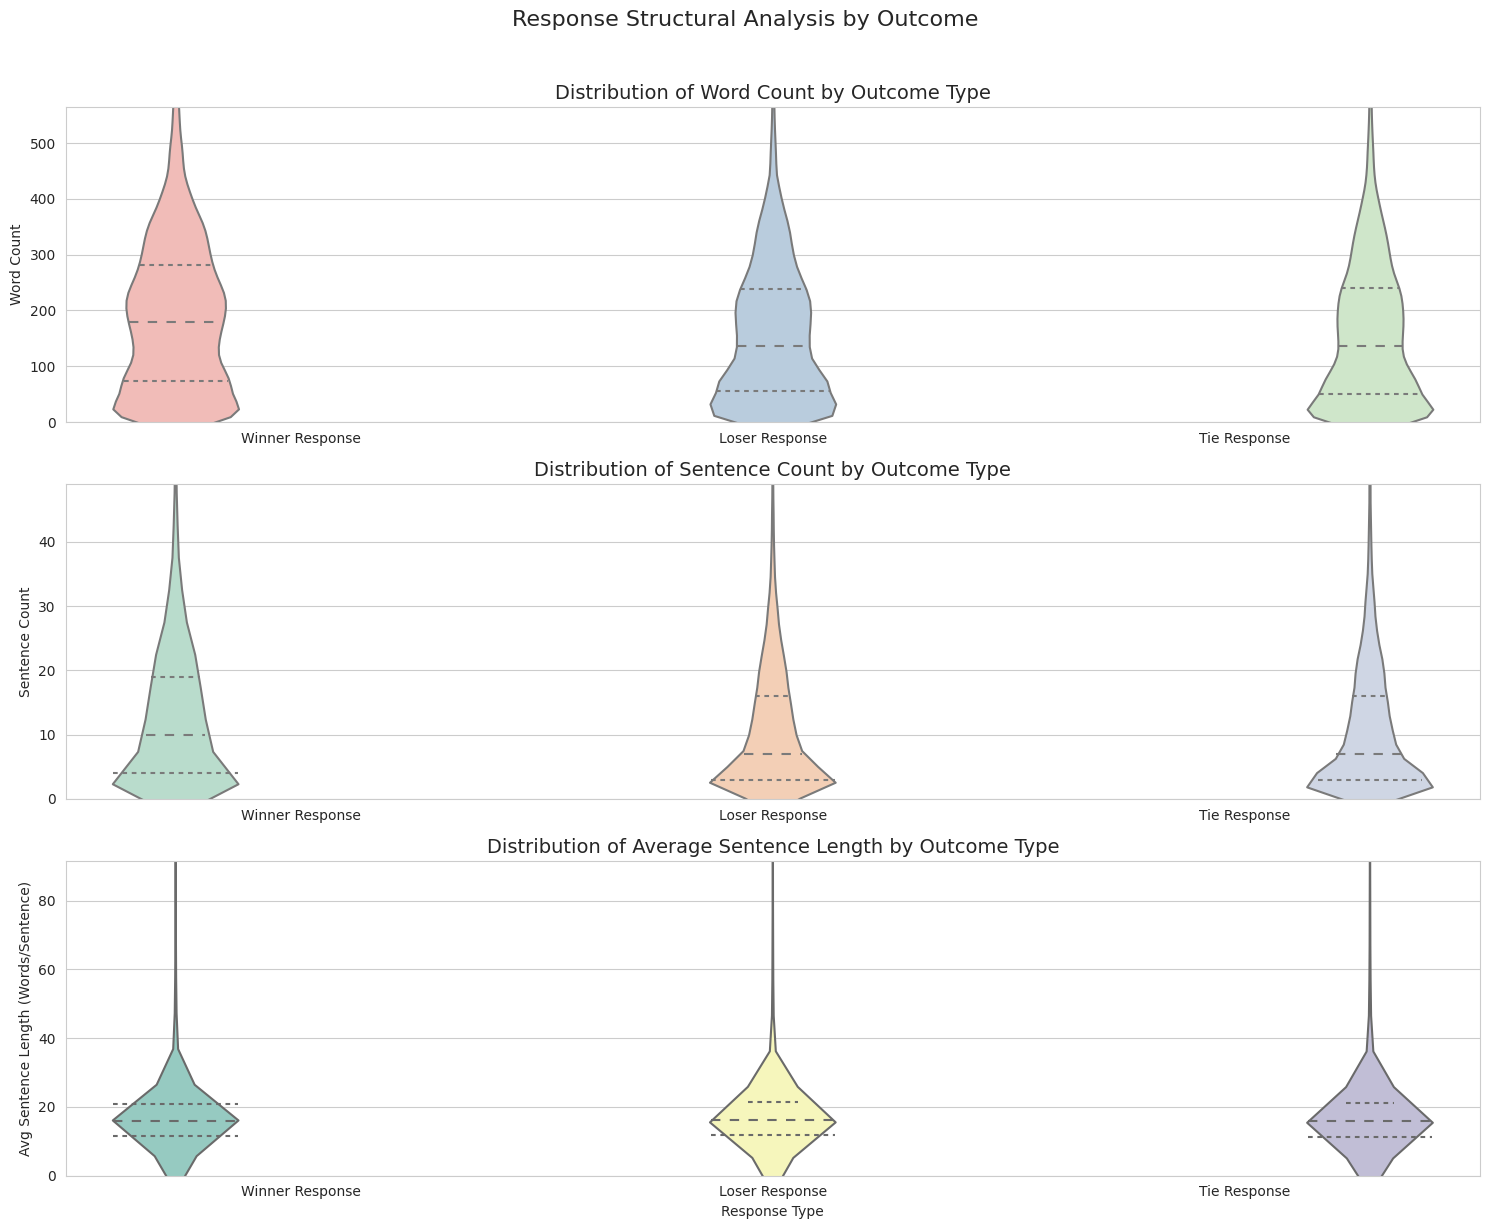

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_response_structure_by_outcome(df):
    """
    Compares the distribution of word count, sentence count, and average sentence length 
    between winning, losing, and tied responses using Violin Plots.
    """
    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=['response_a', 'response_b']).copy()

    # Helper to count sentences (simple estimate using common punctuation)
    def count_sentences(text):
        if not text:
            return 0
        # Count periods, question marks, and exclamation marks
        count = text.count('.') + text.count('?') + text.count('!')
        # A response with content must have at least one sentence. 
        # If no explicit punctuation is found, assume 1 sentence if there are words.
        if count == 0 and len(text.split()) > 0:
            return 1
        return count if count > 0 else 0


    # 1. Calculate new structural features (Word Count, Sentence Count, Avg Sentence Length)
    df_plot['word_count_a'] = df_plot['response_a'].apply(lambda x: len(x.split()))
    df_plot['sent_count_a'] = df_plot['response_a'].apply(count_sentences)
    df_plot['avg_sent_len_a'] = df_plot.apply(
        lambda row: row['word_count_a'] / row['sent_count_a'] if row['sent_count_a'] > 0 else row['word_count_a'], axis=1
    )

    df_plot['word_count_b'] = df_plot['response_b'].apply(lambda x: len(x.split()))
    df_plot['sent_count_b'] = df_plot['response_b'].apply(count_sentences)
    df_plot['avg_sent_len_b'] = df_plot.apply(
        lambda row: row['word_count_b'] / row['sent_count_b'] if row['sent_count_b'] > 0 else row['word_count_b'], axis=1
    )

    # 2. Combine data for plotting

    # Function to extract the length of the winning/losing/tie response for a given feature
    def extract_feature_by_outcome(row, feature_name):
        feature_a = row[f'{feature_name}_a']
        feature_b = row[f'{feature_name}_b']
        
        if row['winner'] == 1:
            return feature_a, feature_b # Winner, Loser
        elif row['winner'] == 2:
            return feature_b, feature_a # Winner, Loser
        else: # Tie
            return feature_a, feature_b # Tie A, Tie B

    # Create master list for features
    data_list = []
    
    for _, row in df_plot.iterrows():
        # Get features
        wc_win, wc_lose = extract_feature_by_outcome(row, 'word_count')
        sc_win, sc_lose = extract_feature_by_outcome(row, 'sent_count')
        asl_win, asl_lose = extract_feature_by_outcome(row, 'avg_sent_len')
        
        # Add Winner/Loser (excluding ties for this part)
        if row['winner'] != 0:
            data_list.append({'Type': 'Winner Response', 'Feature': 'Word Count', 'Value': wc_win})
            data_list.append({'Type': 'Loser Response', 'Feature': 'Word Count', 'Value': wc_lose})
            data_list.append({'Type': 'Winner Response', 'Feature': 'Sentence Count', 'Value': sc_win})
            data_list.append({'Type': 'Loser Response', 'Feature': 'Sentence Count', 'Value': sc_lose})
            data_list.append({'Type': 'Winner Response', 'Feature': 'Avg Sentence Length', 'Value': asl_win})
            data_list.append({'Type': 'Loser Response', 'Feature': 'Avg Sentence Length', 'Value': asl_lose})
        
        # Add Tie Responses
        else:
            data_list.append({'Type': 'Tie Response', 'Feature': 'Word Count', 'Value': wc_win})
            data_list.append({'Type': 'Tie Response', 'Feature': 'Word Count', 'Value': wc_lose})
            data_list.append({'Type': 'Tie Response', 'Feature': 'Sentence Count', 'Value': sc_win})
            data_list.append({'Type': 'Tie Response', 'Feature': 'Sentence Count', 'Value': sc_lose})
            data_list.append({'Type': 'Tie Response', 'Feature': 'Avg Sentence Length', 'Value': asl_win})
            data_list.append({'Type': 'Tie Response', 'Feature': 'Avg Sentence Length', 'Value': asl_lose})


    final_df = pd.DataFrame(data_list)
    # Filter out extreme outliers for better visualization scale (e.g., Word Count > 2000)
    final_df = final_df[final_df['Value'] < 2000]

    # 3. Plot the Violin Plots
    plt.figure(figsize=(15, 12))
    
    # Subplot 1: Word Count
    plt.subplot(3, 1, 1)

    ax1 = sns.violinplot(
        x='Type', 
        y='Value', 
        data=final_df[final_df['Feature'] == 'Word Count'], 
        hue='Type', 
        palette='Pastel1',
        inner='quartile' 
    )
    plt.title('Distribution of Word Count by Outcome Type', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Word Count')
    plt.ylim(0, final_df[final_df['Feature'] == 'Word Count']['Value'].quantile(0.99))
    
    if ax1.legend_:
        ax1.legend_.remove()

    # Subplot 2: Sentence Count
    plt.subplot(3, 1, 2)
    ax2 = sns.violinplot(
        x='Type', 
        y='Value', 
        data=final_df[final_df['Feature'] == 'Sentence Count'], 
        hue='Type', 
        palette='Pastel2', 
        inner='quartile' 
    )
    plt.title('Distribution of Sentence Count by Outcome Type', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Sentence Count')
    plt.ylim(0, final_df[final_df['Feature'] == 'Sentence Count']['Value'].quantile(0.99))
    
    if ax2.legend_:
        ax2.legend_.remove()

    # Subplot 3: Average Sentence Length
    plt.subplot(3, 1, 3)
    ax3 = sns.violinplot(
        x='Type', 
        y='Value', 
        data=final_df[final_df['Feature'] == 'Avg Sentence Length'], 
        hue='Type', 
        palette='Set3', 
        inner='quartile' 
    )
    plt.title('Distribution of Average Sentence Length by Outcome Type', fontsize=14)
    plt.xlabel('Response Type')
    plt.ylabel('Avg Sentence Length (Words/Sentence)')
    plt.ylim(0, final_df[final_df['Feature'] == 'Avg Sentence Length']['Value'].quantile(0.99))
    
    if ax3.legend_:
        ax3.legend_.remove()

    plt.suptitle('Response Structural Analysis by Outcome', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_response_structure_by_outcome(df)

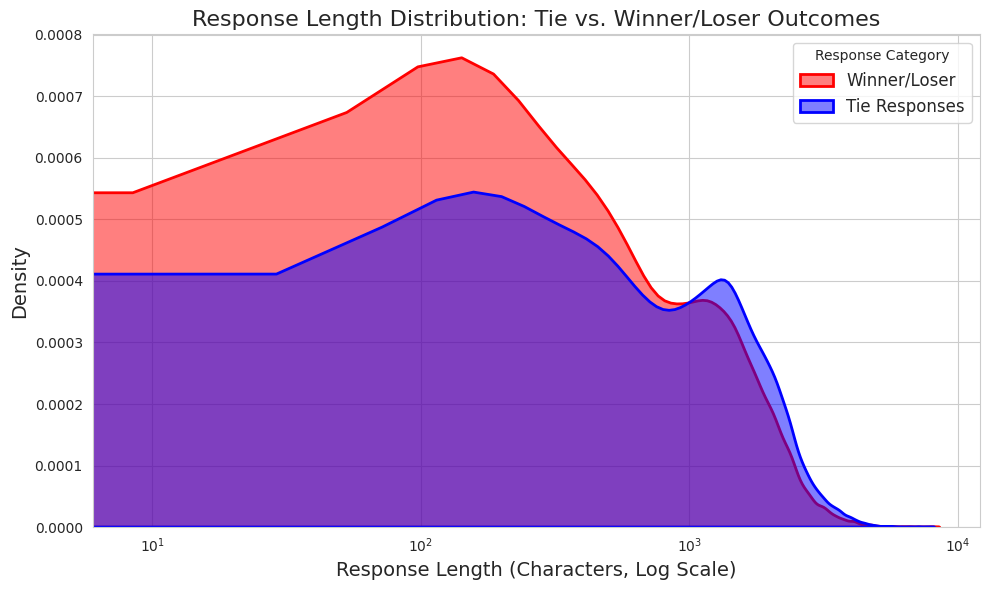

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set consistent style for all plots
sns.set_style("whitegrid")

def plot_tie_response_length_comparison(df):
    """
    Compares the character length distribution of Tie responses vs. Winning/Losing responses.
    """
    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=['response_a', 'response_b']).copy()

    # 1. Calculate response lengths
    df_plot['len_a'] = df_plot['response_a'].apply(len)
    df_plot['len_b'] = df_plot['response_b'].apply(len)

    # 2. Extract lengths for different categories

    # Winning/Losing lengths (only where not a tie)
    win_lose_df = df_plot[df_plot['winner'].isin([1, 2])].copy()
    win_lose_df['Length'] = win_lose_df.apply(
        lambda row: row['len_a'] if row['winner'] == 1 else row['len_b'], axis=1
    )
    win_lose_df['Type'] = 'Winner/Loser' # Combined distribution of non-tie responses

    # Tie lengths
    tie_df = df_plot[df_plot['winner'] == 0].copy()
    tie_a = tie_df.rename(columns={'len_a': 'Length'})
    tie_b = tie_df.rename(columns={'len_b': 'Length'})

    # Combine all tie responses
    tie_combined = pd.concat([tie_a, tie_b])
    tie_combined['Type'] = 'Tie Responses'

    final_df = pd.concat([
        win_lose_df[['Length', 'Type']],
        tie_combined[['Length', 'Type']]
    ]).dropna(subset=['Length'])

    # 3. Plot the density plots (KDE)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=final_df,
        x='Length',
        hue='Type',
        fill=True,
        common_norm=False,
        palette={'Winner/Loser': 'blue', 'Tie Responses': 'red'},
        alpha=.5,
        linewidth=2
    )

    # Use log scale for length to better visualize differences in distribution shape
    plt.xscale('log')

    plt.title('Response Length Distribution: Tie vs. Winner/Loser Outcomes', fontsize=16)
    plt.xlabel('Response Length (Characters, Log Scale)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    ax = plt.gca()
    ax.legend(title='Response Category', labels=['Winner/Loser', 'Tie Responses'], fontsize=12)

    plt.tight_layout()
    plt.show()

# Sequence Length
plot_tie_response_length_comparison(df)


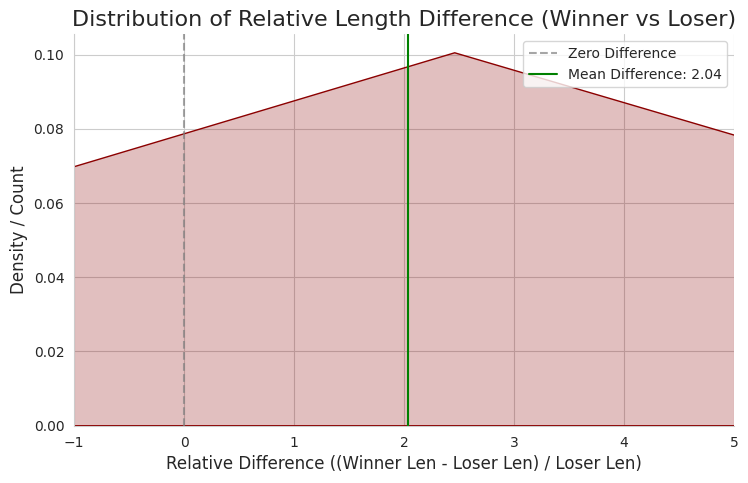

In [50]:

def plot_relative_length_difference(df):
    """
    Analyzes the relative difference in character length between the winning response
    and the losing response in the same head-to-head battle.

    Relative Diff = (Winner Length - Loser Length) / Loser Length
    """

    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=['response_a', 'response_b']).copy()

    # 1. Calculate raw character lengths
    df_plot['len_a'] = df_plot['response_a'].apply(len)
    df_plot['len_b'] = df_plot['response_b'].apply(len)

    # 2. Filter out Tie results, focusing only on comparisons with clear winners
    df_results = df_plot[df_plot['winner'].isin([1, 2])].copy()

    # 3. Extract Winner and Loser lengths
    # Winner length
    df_results['winner_len'] = df_results.apply(
        lambda row: row['len_a'] if row['winner'] == 1 else row['len_b'], axis=1
    )
    # Loser length
    df_results['loser_len'] = df_results.apply(
        lambda row: row['len_b'] if row['winner'] == 1 else row['len_a'], axis=1
    )

    # 4. Calculate Relative Length Difference
    # Avoid division by zero: only calculate for rows where loser_len > 0
    df_results = df_results[df_results['loser_len'] > 0].copy()

    df_results['relative_diff'] = (
        (df_results['winner_len'] - df_results['loser_len']) / df_results['loser_len']
    )

    # 5. Plot Kernel Density Estimate (KDE)

    g = sns.displot(
        data=df_results,
        x='relative_diff',
        kind='kde', # Use KDE for shape visualization
        color='darkred',
        fill=True,
        height=5,
        aspect=1.5
    )

    # Add vertical line for 0% difference
    g.ax.axvline(0, color='grey', linestyle='--', alpha=0.7, label='Zero Difference')

    # Add mean relative difference line
    mean_diff = df_results['relative_diff'].mean()
    g.ax.axvline(mean_diff, color='green', linestyle='-', label=f'Mean Difference: {mean_diff:.2f}')

    # Limit X-axis range to focus on the core distribution
    g.set(xlim=(-1.0, 5.0))

    # Set titles and labels
    g.ax.set_title('Distribution of Relative Length Difference (Winner vs Loser)', fontsize=16)
    g.set_axis_labels(
        'Relative Difference ((Winner Len - Loser Len) / Loser Len)',
        'Density / Count',
        fontsize=12
    )
    g.ax.legend(fontsize=10)

    # Adjust top margin
    g.fig.subplots_adjust(top=0.9)
    
    plt.show()

# Sequence Length
plot_relative_length_difference(df)


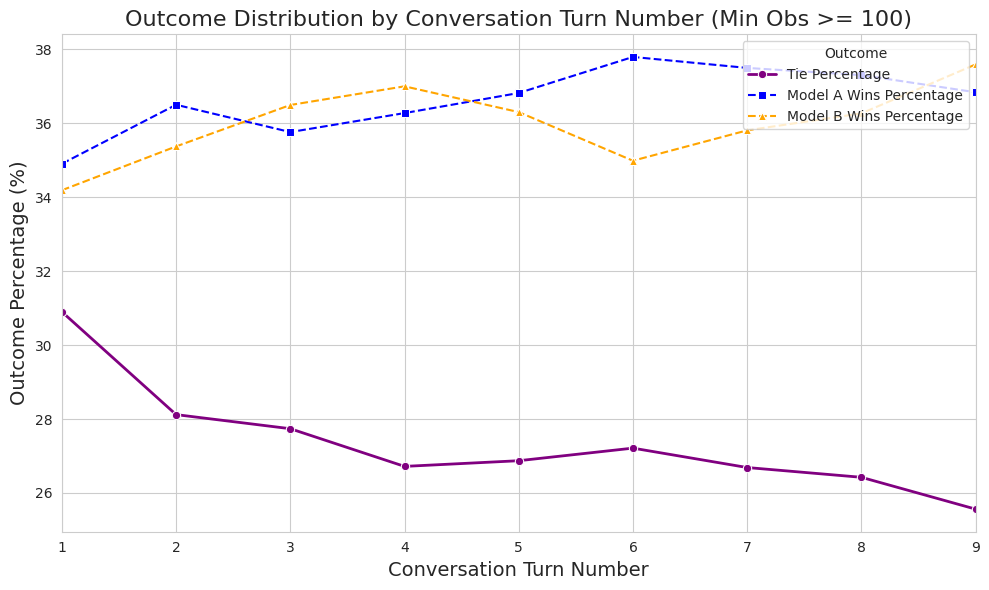

In [51]:

def plot_conversation_depth_analysis(df):
    """
    Analyzes how the 'Turn Number' (depth of the conversation) affects the outcome,
    specifically the percentage of ties.

    This function requires the DataFrame to have the original 'id' (which was copied
    during the expand_df step) to group the conversation turns.
    """
    df_plot = df.copy()

    # 1. Create a new feature: Conversation Turn Number
    # For each original id (i.e., each conversation), assign an incremental number (1, 2, 3...)
    df_plot['turn_number'] = df_plot.groupby('id').cumcount() + 1

    # 2. Calculate the wins and total comparisons for each turn number
    turn_analysis = df_plot.groupby('turn_number').agg(
        total_comparisons=('id', 'count'),
        ties=('winner', lambda x: (x == 0).sum()),
        a_wins=('winner', lambda x: (x == 1).sum()),
        b_wins=('winner', lambda x: (x == 2).sum())
    ).reset_index()

    # 3. Calculate the key metric: Tie Percentage
    turn_analysis['tie_percentage'] = (turn_analysis['ties'] / turn_analysis['total_comparisons']) * 100

    # 4. Calculate key metrics: A and B win percentages (for comprehensive analysis)

    turn_analysis['A_win_percentage'] = (turn_analysis['a_wins'] / turn_analysis['total_comparisons']) * 100
    turn_analysis['B_win_percentage'] = (turn_analysis['b_wins'] / turn_analysis['total_comparisons']) * 100

    # Filter out turns with too few data points to ensure reliability
    min_obs = 100
    turn_analysis = turn_analysis[turn_analysis['total_comparisons'] >= min_obs].copy()

    if turn_analysis.empty:
        print(f"No turns meet the minimum observation count of {min_obs}. Skipping plot.")
        return

    # 5. Plot the line chart

    plt.figure(figsize=(10, 6))

    # Plot Tie Percentage (Main line)
    sns.lineplot(
        x='turn_number',
        y='tie_percentage',
        data=turn_analysis,
        marker='o',
        label='Tie Percentage',
        color='purple',
        linewidth=2
    )

    # Plot A and B Win Percentages (for context)
    sns.lineplot(
        x='turn_number',
        y='A_win_percentage',
        data=turn_analysis,
        marker='s',
        label='Model A Wins Percentage',
        color='blue',
        linestyle='--'
    )
    sns.lineplot(
        x='turn_number',
        y='B_win_percentage',
        data=turn_analysis,
        marker='^',
        label='Model B Wins Percentage',
        color='orange',
        linestyle='--'
    )

    plt.title(f'Outcome Distribution by Conversation Turn Number (Min Obs >= {min_obs})', fontsize=16)
    plt.xlabel('Conversation Turn Number', fontsize=14)
    plt.ylabel('Outcome Percentage (%)', fontsize=14)
    plt.legend(title='Outcome', loc='upper right')
    plt.grid(True)
    plt.xlim(1, turn_analysis['turn_number'].max())

    plt.tight_layout()
    plt.show()

# up down context
plot_conversation_depth_analysis(df)